
# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel

### Sobre
 
No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.
 
O interessado em alugar seu imóvel, cadastra e cria seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e em seguida cria o anúncio do seu imóvel.
 
Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)
 
### Nosso objetivo
 
Construir um modelo de previsão de preço para que pessoas que tenham interesse em alugar seu imóvel possam ter informações para saber quanto poderia cobrar pela diária do seu imóvel.
 
Assim como, para quem tenha interesse em alugar um imóvel, pode avaliar se o preço cobrado, de acordo com as características do imóvel, está atrativo.
 
### Dados e créditos
 
As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro
 
- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados.
 
Créditos: 
 
Ao coordenador do treinamento Lira e a toda equipe da Hashtag Treinamentos
 
https://www.hashtagtreinamentos.com/
 
### Expectativas Iniciais
 
- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

### Importar Bibliotecas e Bases de Dados

In [2]:
# Importar biblioteca para acessar o google drive
from google.colab import drive
drive.mount(r'/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import pathlib  # precisamos percorrer todos arquivos da pasta, usa-se a biblioteca 'pathlib'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [4]:
caminho_bases = pathlib.Path(r'/content/drive/MyDrive/Airbnb Rio')

for arquivo in caminho_bases.iterdir():
    print(arquivo.name)

abril2019.csv
agosto2019.csv
dezembro2019.csv
janeiro2019.csv
fevereiro2019.csv
julho2019.csv
novembro2019.csv
junho2019.csv
maio2019.csv
maro2019.csv
outubro2019.csv
setembro2019.csv
novembro2018.csv
dezembro2018.csv
julho2018.csv
maio2018.csv
outubro2018.csv
setembro2018.csv
agosto2018.csv
abril2018.csv
janeiro2020.csv
maio2020.csv
maro2020.csv
fevereiro2020.csv
abril2020.csv


### Consolidar Base de Dados

In [5]:
base_airbnb = pd.DataFrame()

meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

for arquivo in caminho_bases.iterdir():
    
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    # Concatenar, juntar duas pasta, usa '/'
    df = pd.read_csv(caminho_bases/arquivo.name)   
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)
    
display(base_airbnb) 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ano,mes
0,17878,https://www.airbnb.com/rooms/17878,20190416181629,2019-04-16,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.10,2019,4
1,25026,https://www.airbnb.com/rooms/25026,20190416181629,2019-04-16,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,strict_14_with_grace_period,t,t,3,3.0,0.0,0.0,2.12,2019,4
2,31560,https://www.airbnb.com/rooms/31560,20190416181629,2019-04-17,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.33,2019,4
3,35636,https://www.airbnb.com/rooms/35636,20190416181629,2019-04-17,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,strict_14_with_grace_period,t,t,1,1.0,0.0,0.0,2.20,2019,4
4,35764,https://www.airbnb.com/rooms/35764,20190416181629,2019-04-16,COPACABANA SEA BREEZE - RIO,Our newly renovated studio is located in the b...,"FEEL LIKE YOUR HOME LIVING AS ""CARIOCA"" LOCAL ...",Our newly renovated studio is located in the b...,none,Our guests will experience living with a local...,...,strict_14_with_grace_period,f,t,1,1.0,0.0,0.0,2.80,2019,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35865,43222409,https://www.airbnb.com/rooms/43222409,20200420135919,2020-04-22,Suíte fenomenal em mansão de luxo,NaN,NaN,NaN,none,NaN,...,flexible,f,f,5,1.0,4.0,0.0,NaN,2020,4
35866,43222788,https://www.airbnb.com/rooms/43222788,20200420135919,2020-04-21,Quarto Casal Individual ARPOADOR / IPANEMA,"IPANEMA, QUARTO INDIVIDUAL. Moramos em 2 meni...",NaN,"IPANEMA, QUARTO INDIVIDUAL. Moramos em 2 meni...",none,"O Ap está completo é cobertura. 2 Portarias, R...",...,flexible,f,f,1,0.0,1.0,0.0,NaN,2020,4
35867,43222989,https://www.airbnb.com/rooms/43222989,20200420135919,2020-04-21,Perto da praia? Aqui mesmo. Copacabana!,"Apartamento aconchegante e silencioso, uma qua...",Estamos alugando para profissionais da área de...,"Apartamento aconchegante e silencioso, uma qua...",none,É um bairro que até nos lugares mais longiquo...,...,flexible,f,f,2,2.0,0.0,0.0,NaN,2020,4
35868,43223062,https://www.airbnb.com/rooms/43223062,20200420135919,2020-04-21,Loft confortável para sua estadia.,"Excelente apartamento todo reformado, silencio...",NaN,"Excelente apartamento todo reformado, silencio...",none,NaN,...,moderate,f,f,1,1.0,0.0,0.0,NaN,2020,4


In [6]:
print(base_airbnb.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'ano', 'mes'],
      dtype='object', length=108)


- Como temos muitas colunas, isso pode deixar nosso modelo muito lento.
- Fazendo uma análise rápida, podemos identificar que algumas colunas não são necessárias para o nosso modelo
- Tipos de colunas que vamos excluir:

  1 - IDs, links e informações não relevantes para o modelo.

  2 - Colunas repetidas e extremamente parecida com outra (que dão a mesma informação para o modelo). Ex: Data x Ano/Mês.

  3 - Colunas com textos livres, não rodaremos nenhuma análise de palavras.

  4 - Colunas em que todos ou quase todos valores são iguais.


- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa

In [7]:
# Salvando os 1.000 primeiros registros em excel 
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

### Analisando as colunas no excel

In [8]:
print(base_airbnb[['experiences_offered']].value_counts())

experiences_offered
none                   902210
dtype: int64


In [9]:
print(base_airbnb[['host_acceptance_rate']].value_counts())

host_acceptance_rate
100%                    31697
0%                       4744
50%                      3781
99%                      3320
67%                      3140
                        ...  
16%                        22
15%                        21
7%                         20
51%                        18
6%                         11
Length: 100, dtype: int64


In [10]:
# Comparar duas colunas
comparacao = base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']
print(comparacao)

0        True
1        True
2        True
3        True
4        True
         ... 
35865    True
35866    True
35867    True
35868    True
35869    True
Length: 902210, dtype: bool


In [11]:
print(comparacao.value_counts())

True     901750
False       460
dtype: int64


In [12]:
print(base_airbnb['square_feet'].isnull().sum())

888162


### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [13]:
# Após aplicar a função 'JOIN' no excel, copiamos e colamos todas as colunas juntas,
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

In [14]:
# Filtrar a base do Airbnb
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,within an hour,100%,f,2.0,-22.96592,-43.17896,Condominium,Entire home/apt,5,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,4
1,within a day,88%,f,3.0,-22.97712,-43.19045,Apartment,Entire home/apt,3,1.0,...,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,4
2,within an hour,100%,t,1.0,-22.98302,-43.21427,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,4
3,within a few hours,100%,t,1.0,-22.98816,-43.19359,Apartment,Entire home/apt,3,1.5,...,9.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,4
4,within an hour,100%,t,1.0,-22.98127,-43.19046,Loft,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35865,within an hour,91%,f,2.0,-22.98356,-43.30366,House,Private room,2,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2020,4
35866,NaN,NaN,f,0.0,-22.98526,-43.19385,Apartment,Private room,2,2.0,...,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2020,4
35867,within a few hours,100%,f,2.0,-22.97516,-43.19261,Apartment,Entire home/apt,3,1.0,...,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2020,4
35868,NaN,NaN,f,0.0,-22.96379,-43.17193,Loft,Entire home/apt,2,1.0,...,NaN,NaN,NaN,NaN,NaN,t,f,moderate,2020,4


### Tratar Valores Faltando

- Visualizando os dados, identificamos colunas com valores NaN acima de 300.000, essas colunas serão excluídas da análise.

- Para as outras colunas, como temos muitos dados, cerca de 900.000 linhas, vamos excluir as linhas que contém dados NaN

In [15]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [16]:
# Selecionar as colunas com valores NaN maior que 300.000 e excluí-las
for coluna in base_airbnb:
  if base_airbnb[coluna].isnull().sum() > 300000:
    base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [17]:
base_airbnb = base_airbnb.dropna()

base_airbnb.shape

(897709, 23)

In [18]:
# Verificando se existem linhas vazios
base_airbnb.isnull().sum()

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64

### Verificar Tipos de Dados em cada coluna

In [21]:
print(base_airbnb.dtypes)
print('-'*78)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------------------------
host_is_superhost                                                           f
h

- Como 'price' e 'extra_people' estão sendo reconhecido como objeto (ao invés de ser um float), temos que mudar o tipo de variável da coluna.

In [22]:
# Alterar 'price'
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# Alterar 'extra_people'
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [23]:
base_airbnb.describe()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,ano,mes
count,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,8.977090e+05,897709.000000,897709.000000,897709.000000
mean,8.540508,-22.965346,-43.253856,4.211794,1.695061,1.645698,2.601979,647.922180,1.677594,40.158718,4.559410,4.182215e+04,7.730099,2018.862824,6.326888
std,47.083956,0.034776,0.097373,2.613927,1.197992,1.078560,2.069426,1705.998169,1.529591,98.540802,20.889129,7.321626e+06,21.819157,0.716148,3.398323
min,0.000000,-23.073400,-43.738920,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,2018.000000,1.000000
25%,1.000000,-22.984690,-43.322560,2.000000,1.000000,1.000000,1.000000,151.000000,1.000000,0.000000,1.000000,3.000000e+01,0.000000,2018.000000,4.000000
50%,1.000000,-22.970675,-43.200070,4.000000,1.000000,1.000000,2.000000,297.000000,1.000000,0.000000,2.000000,1.125000e+03,1.000000,2019.000000,6.000000
75%,3.000000,-22.946080,-43.186930,6.000000,2.000000,2.000000,3.000000,601.000000,2.000000,50.000000,4.000000,1.125000e+03,4.000000,2019.000000,9.000000
max,1495.000000,-22.748953,-43.103709,160.000000,200.000000,45.000000,86.000000,138288.000000,36.000000,5631.000000,1224.000000,2.147484e+09,401.000000,2020.000000,12.000000


### Análise Exploratória e Tratar Outliers

Análise Exploratória e Tratar Outliers
- Vamos basicamente olhar feature por feature para:

1 - Ver a correlação entre as features e decidir se manteremos todas as features que temos.

2 - Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1

3 - Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

Antes de excluir os outliers, não podemos esquecer do objetivo final do projeto, pois podem existir outliers que seja necessário para o modelo e a exclusão pode ser prejudicial.


In [24]:
# Primeiro vamos analisar a correlação entre todas colunas, usando a função 'corr()'
print(base_airbnb.corr())

                     host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034115   0.063635      0.069320   
latitude                       -0.034115  1.000000   0.370416     -0.142082   
longitude                       0.063635  0.370416   1.000000     -0.121746   
accommodates                    0.069320 -0.142082  -0.121746      1.000000   
bathrooms                       0.022332 -0.169135  -0.170504      0.521909   
bedrooms                        0.039712 -0.165050  -0.186332      0.675913   
beds                            0.042788 -0.113931  -0.110392      0.692740   
price                           0.092306 -0.092437  -0.085526      0.269929   
guests_included                 0.041932 -0.091123   0.049375      0.317563   
extra_people                   -0.031589 -0.041113   0.001723      0.078709   
minimum_nights                 -0.006441 -0.016090  -0.019213      0.024583   
maximum_nights                 -0.000100 -0.001386  

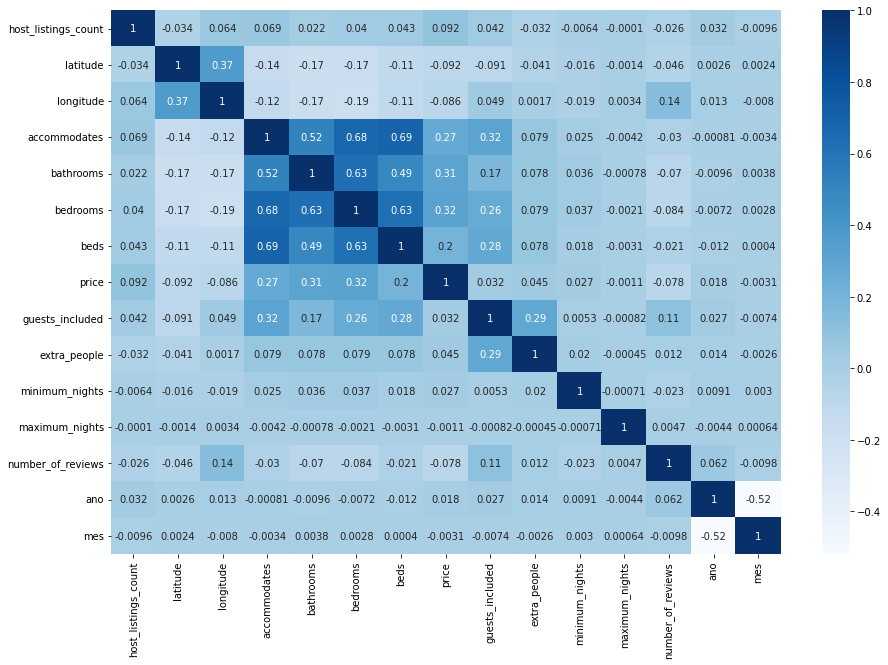

In [25]:
# Melhor maneira de analisar a correlação entre as colunas, é melhor utilizar um 'Mapa de Calor'
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Blues')

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [26]:
# q1-> 1o. quartil, q3-> 3o. quartil, amplitude = q3-q1. Isso é Estatística para definir limites superiores e inferiores
def limites(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1
  return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude 

In [27]:
# definir a função para excluir outliers
def excluir_outliers(df, nome_coluna):
  qtde_linhas = df.shape[0]
  lim_inf, lim_sup = limites(df[nome_coluna])
  df = df.loc[(df[nome_coluna] > lim_inf) & (df[nome_coluna] <= lim_sup), :]
  linhas_removidas = qtde_linhas - df.shape[0]
  return df, linhas_removidas


In [28]:
# Testanda a função com a coluna 'price'
print(limites(base_airbnb['price']))

(-524.0, 1276.0)


In [29]:
# Criar funções para impessão dos gráficos
def diagrama_caixa(coluna):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(15, 5)
  sns.boxplot(x=coluna, ax=ax1)
  ax2.set_xlim(limites(coluna))
  sns.boxplot(x=coluna, ax=ax2) 

def histograma(coluna):
  plt.figure(figsize=(15,5))
  sns.distplot(coluna, hist=True)

def grafico_barra(coluna):
  plt.figure(figsize=(15,5))
  ax = sns.barplot(x = coluna.value_counts().index , y = coluna.value_counts())
  ax.set_xlim(limites(coluna))

### Price



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


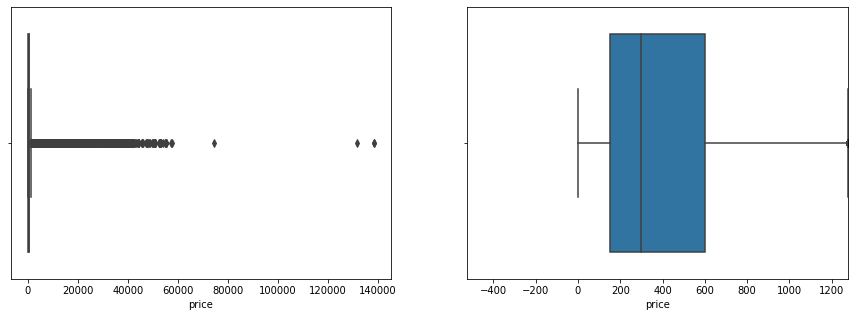

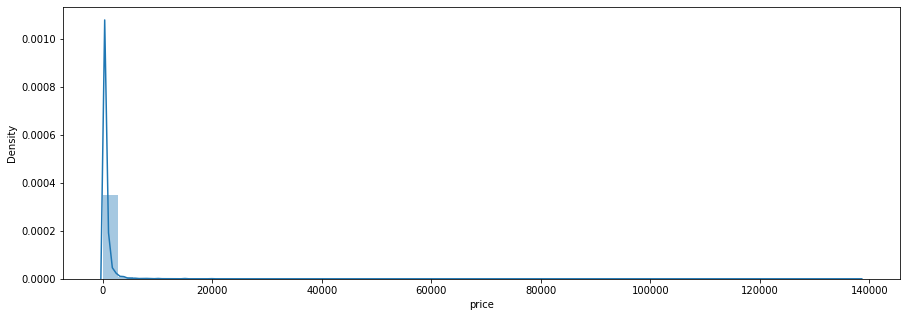

In [30]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que imóveis acima do nosso limite superior, são de altíssimo luxo. Não é o nosso objetivo principal, e por isso podemos excluir estes outliers.

In [31]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 23)


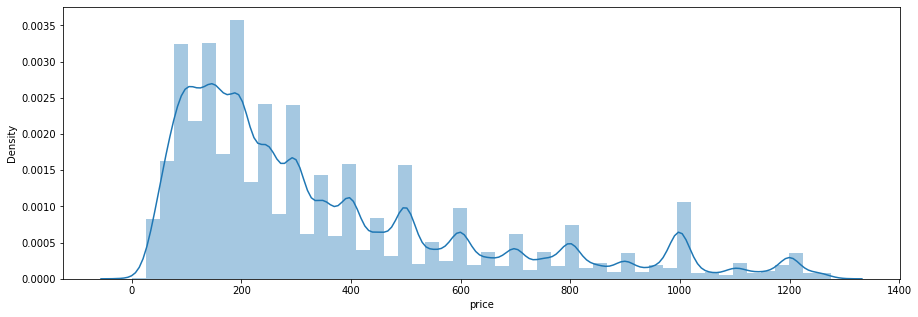

In [32]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### Extra People

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


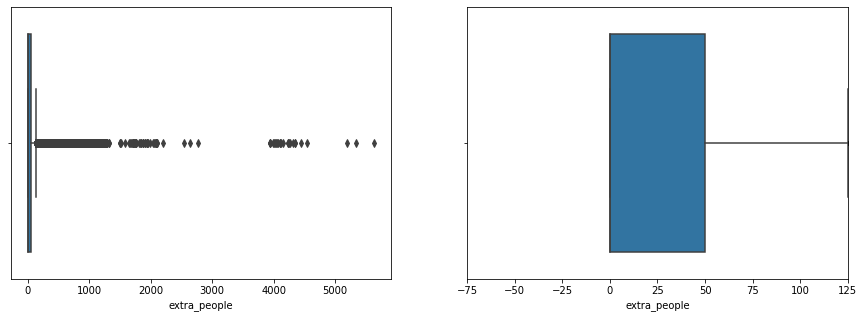

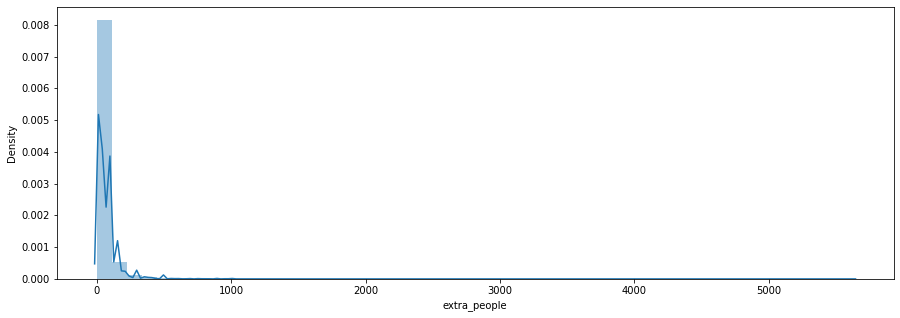

In [33]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [34]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(751233, 23)


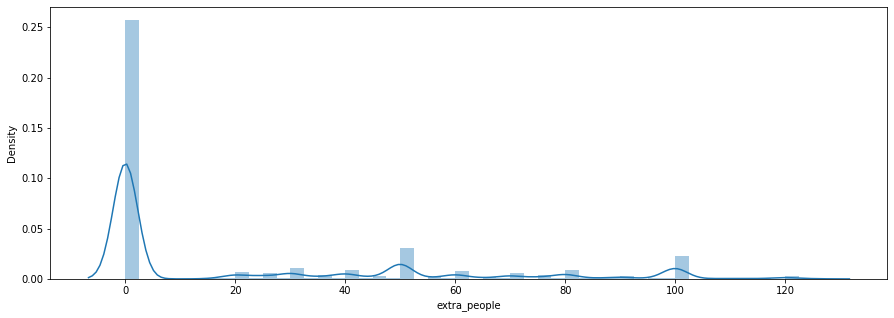

In [35]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

In [36]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

7309 linhas removidas


### host_listings_count

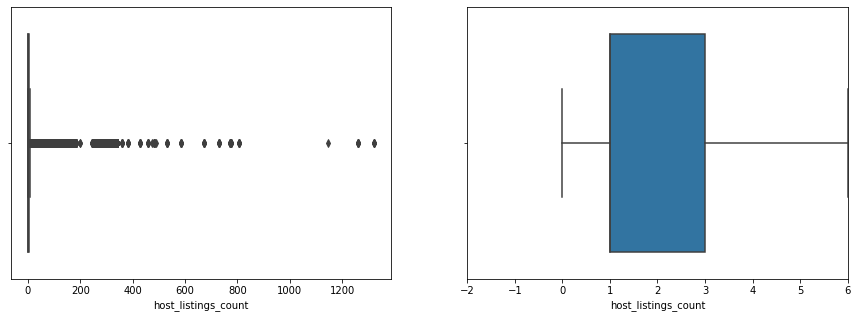

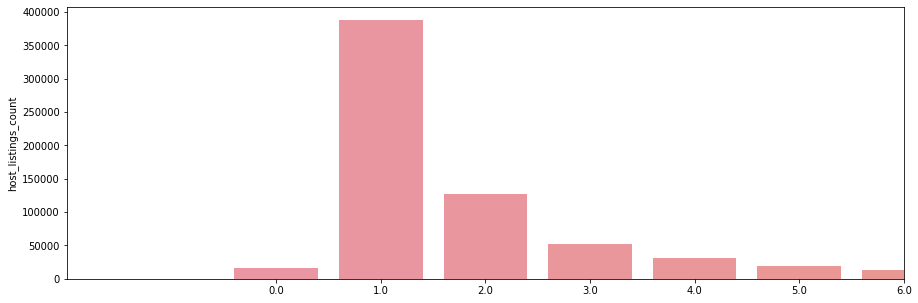

In [37]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, por que host com mais de 06 imóveis no Airbnb não é o público alvo do nosso projeto

In [38]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

96659 linhas removidas


### accommodates

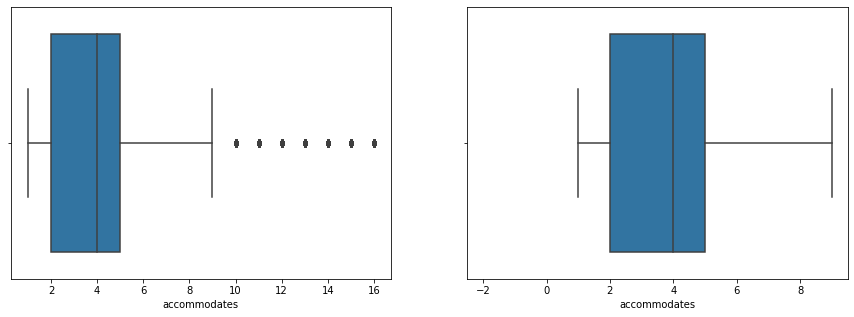

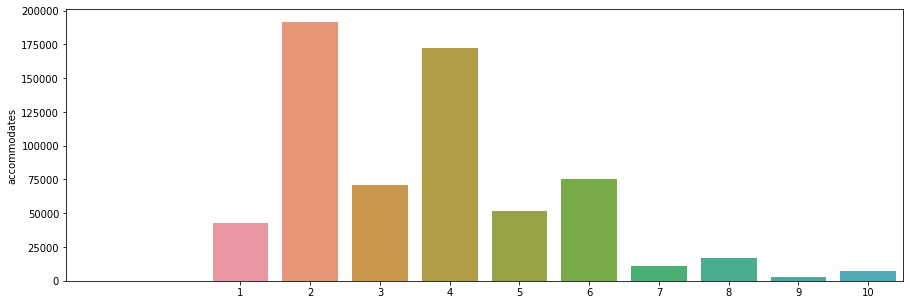

In [39]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [40]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

12910 linhas removidas


### bathrooms

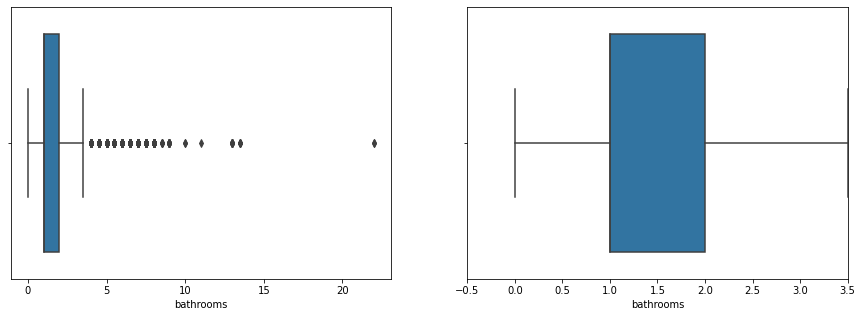

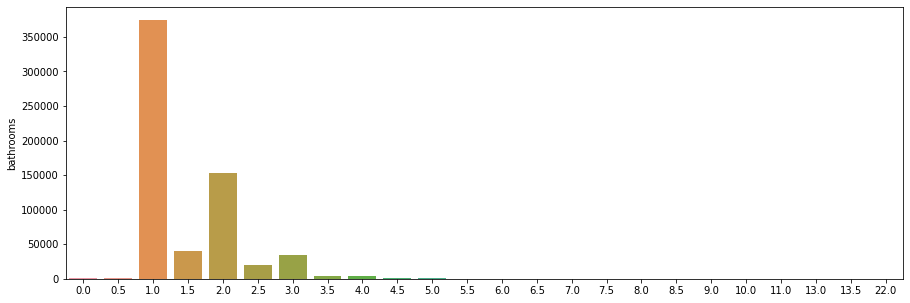

In [41]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [42]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6796 linhas removidas


### bedrooms

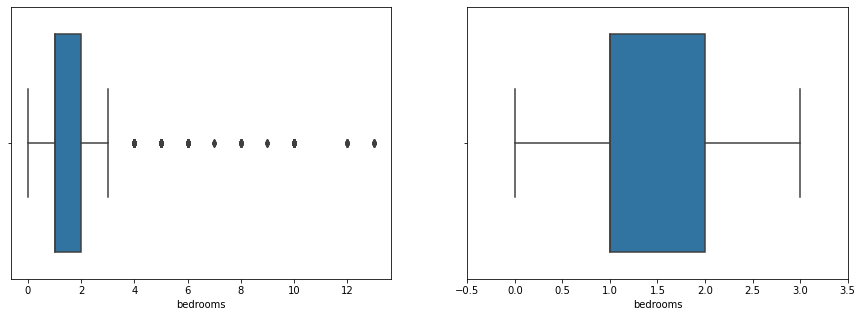

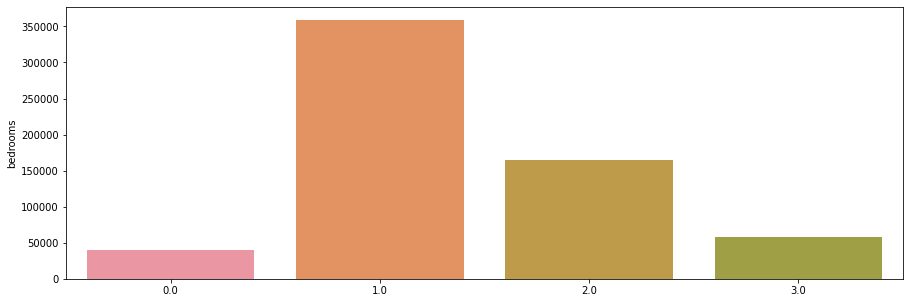

In [43]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [44]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5409 linhas removidas


### beds

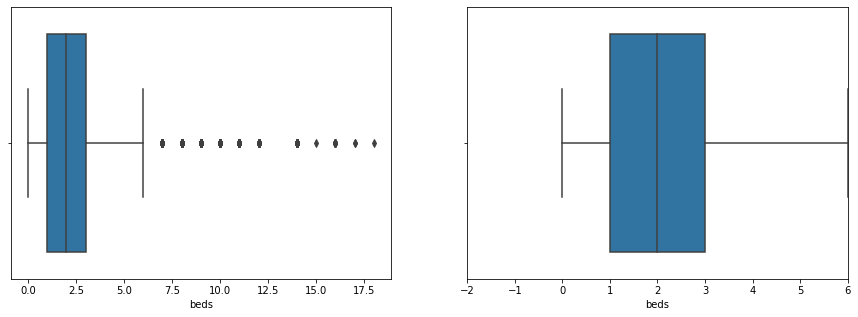

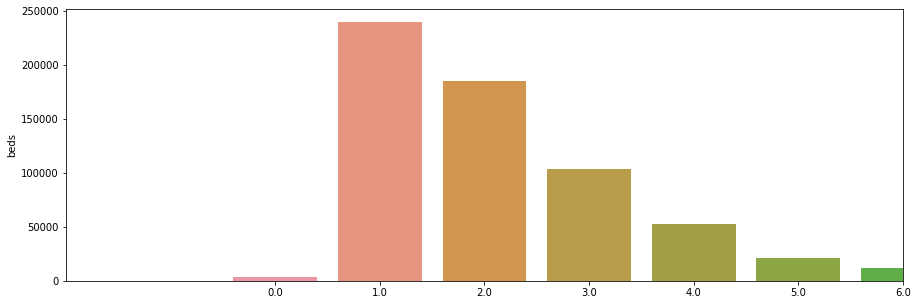

In [45]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [46]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5518 linhas removidas


### guests_included

(1.0, 1.0)


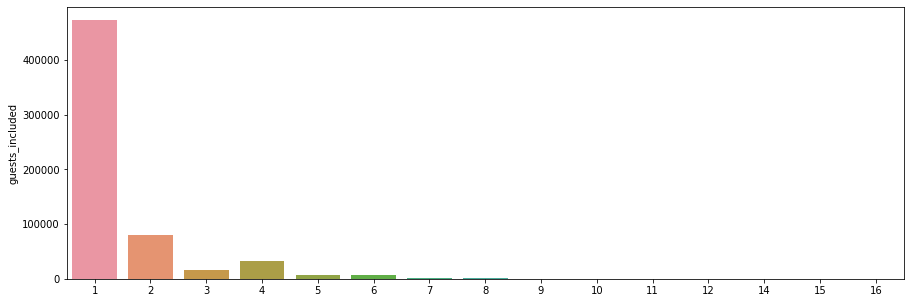

In [47]:
# diagrama_caixa(base_airbnb['guests_included'])
# grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise, pois parece que os usuários do Airbnb usam muito o valor padrão 1 no guests_included. Isso pode levar o nosso modelo uma feature que não é essêncial ao preço, sendo assim é melhor excluir da análise

In [48]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(616632, 22)

### minimum_nights

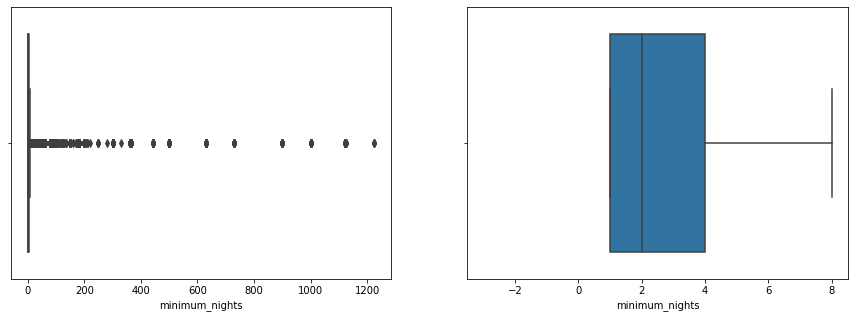

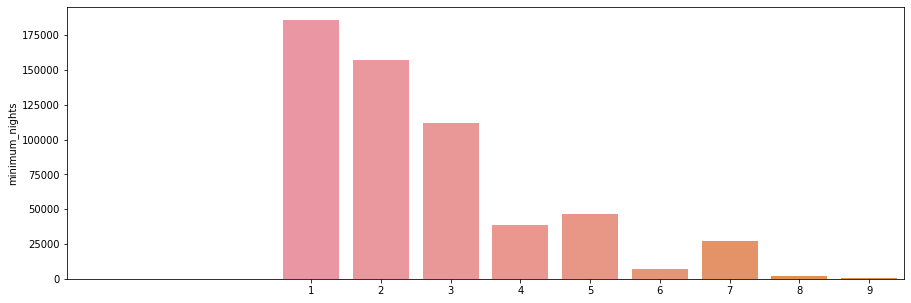

In [49]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [ ]:
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40187 linhas removidas


### maximum_nights

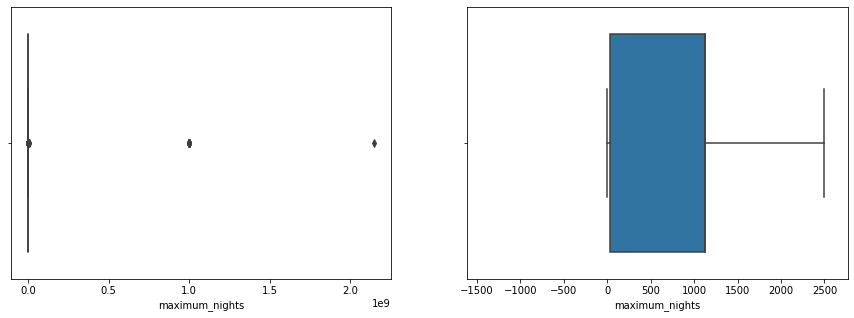

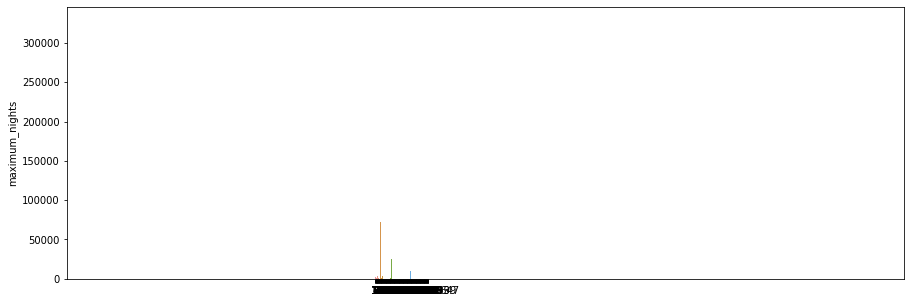

In [50]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [51]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(616632, 21)

### number_of_reviews 

             



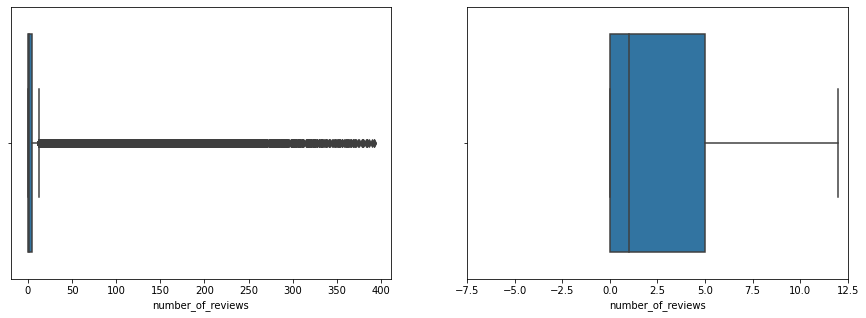

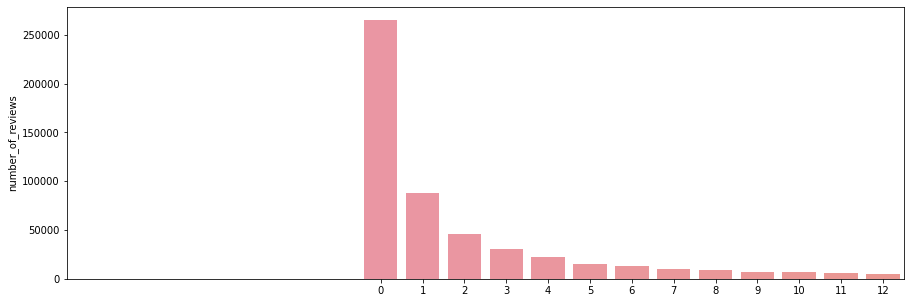

In [52]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

Como nosso modelo é para usuários comuns e até mesmo novos, vamos remover essa feature da análise, pois novos usuários ainda não terão nenhum review

In [53]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(616632, 20)

### Tratamento de Colunas com Valores em Texto

- property_type

Apartment                 488443
House                      53708
Condominium                27407
Serviced apartment         13050
Loft                       12544
Guest suite                 3731
Bed and breakfast           3492
Hostel                      2839
Guesthouse                  2209
Other                       2041
Villa                       1363
Townhouse                   1011
Aparthotel                   703
Earth house                  540
Tiny house                   488
Chalet                       479
Boutique hotel               449
Hotel                        372
Casa particular (Cuba)       328
Cottage                      247
Bungalow                     213
Dorm                         191
Cabin                        141
Nature lodge                 124
Treehouse                     76
Boat                          65
Castle                        57
Island                        54
Hut                           40
Resort                        31
Tent      

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


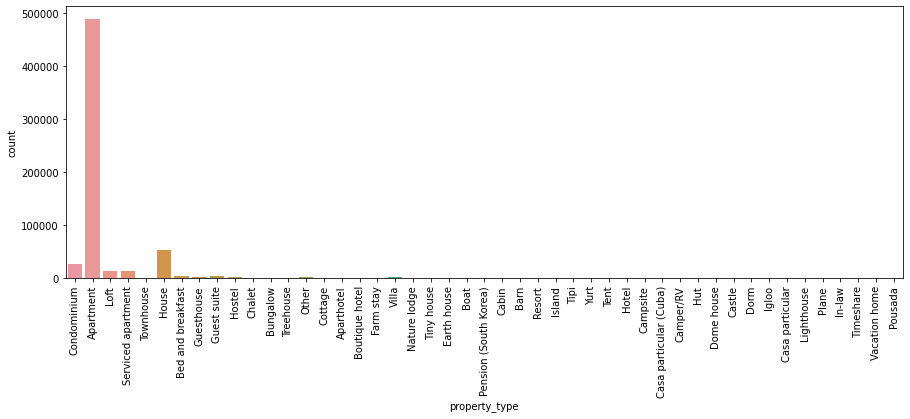

In [54]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [55]:
tabela_tipo_imoveis = base_airbnb['property_type'].value_counts()
print(tabela_tipo_imoveis)
print('---'*60)
print(tabela_tipo_imoveis.index)

Apartment                 488443
House                      53708
Condominium                27407
Serviced apartment         13050
Loft                       12544
Guest suite                 3731
Bed and breakfast           3492
Hostel                      2839
Guesthouse                  2209
Other                       2041
Villa                       1363
Townhouse                   1011
Aparthotel                   703
Earth house                  540
Tiny house                   488
Chalet                       479
Boutique hotel               449
Hotel                        372
Casa particular (Cuba)       328
Cottage                      247
Bungalow                     213
Dorm                         191
Cabin                        141
Nature lodge                 124
Treehouse                     76
Boat                          65
Castle                        57
Island                        54
Hut                           40
Resort                        31
Tent      

In [56]:
# criar uma coluna auxiliar para agrupar imoveis com quantidade menor de 2000
colunas_agrupada = []

for tipo in tabela_tipo_imoveis.index:
  if tabela_tipo_imoveis[tipo] < 2000:
    colunas_agrupada.append(tipo)

print(colunas_agrupada)

['Villa', 'Townhouse', 'Aparthotel', 'Earth house', 'Tiny house', 'Chalet', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Treehouse', 'Boat', 'Castle', 'Island', 'Hut', 'Resort', 'Tent', 'Campsite', 'Camper/RV', 'Yurt', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Casa particular', 'Timeshare', 'Pousada', 'Lighthouse', 'Plane']


In [57]:
for tipo in colunas_agrupada:
  base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

Apartment             488443
House                  53708
Condominium            27407
Serviced apartment     13050
Loft                   12544
Outros                  7168
Guest suite             3731
Bed and breakfast       3492
Hostel                  2839
Guesthouse              2209
Other                   2041
Name: property_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


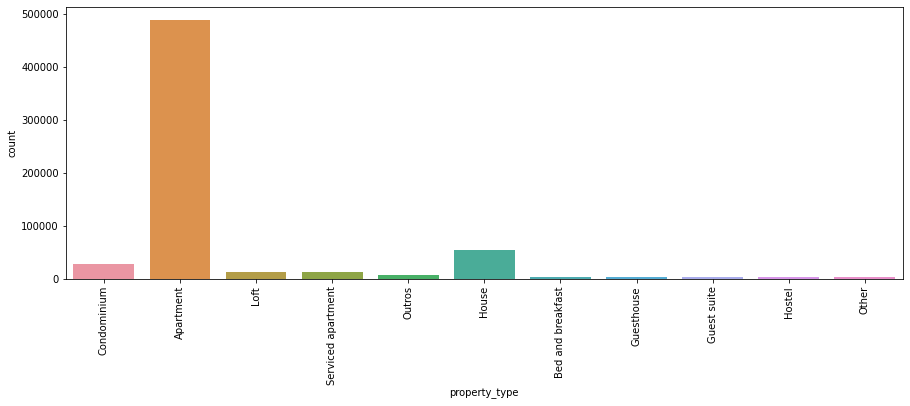

In [58]:
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- room_type

Entire home/apt    400701
Private room       202507
Shared room         12439
Hotel room            985
Name: room_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


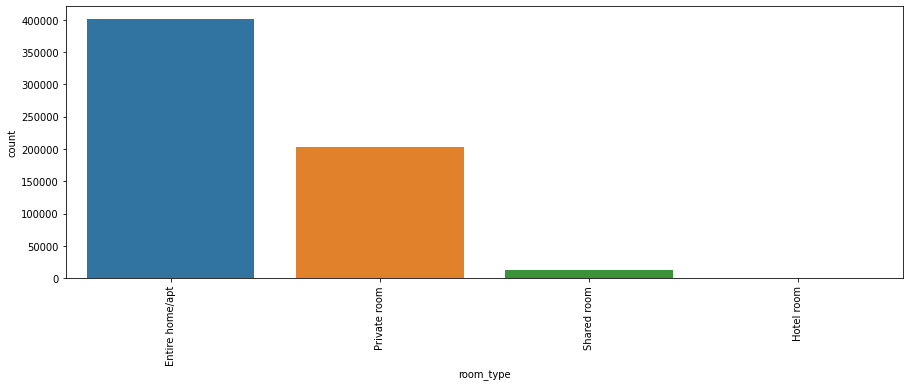

In [59]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- bed_type

Real Bed         604568
Pull-out Sofa      8419
Futon              1719
Airbed             1349
Couch               577
Name: bed_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


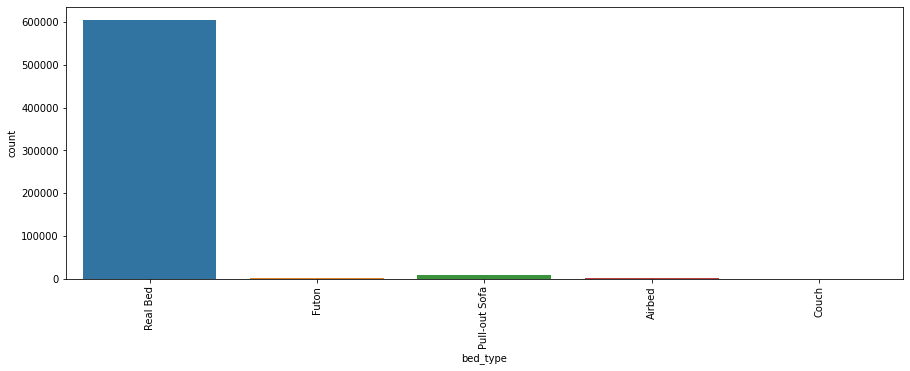

In [60]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [61]:
# Agrupando os tipos de camas
colunas_agrupada = []

tabela_tipo_cama = base_airbnb['bed_type'].value_counts()

for tipo in tabela_tipo_cama.index:
  if tabela_tipo_cama[tipo] < 10000:
    colunas_agrupada.append(tipo)

print(colunas_agrupada)


['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']


In [62]:
for tipo in colunas_agrupada:
  base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())

Real Bed    604568
Outros       12064
Name: bed_type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


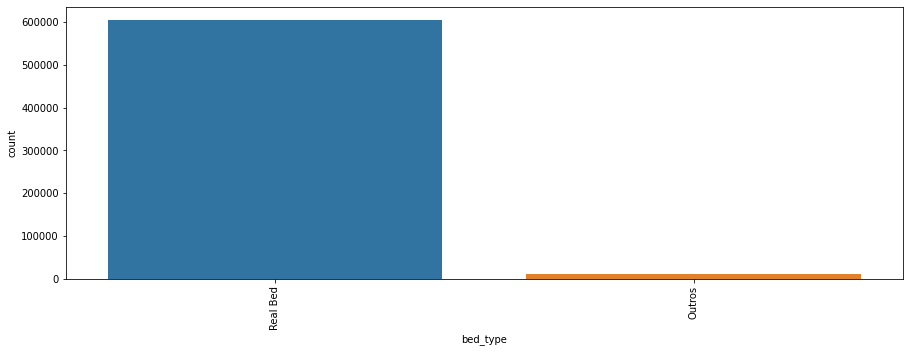

In [63]:
plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- cancellation_policy

flexible                       280480
strict_14_with_grace_period    209596
moderate                       116322
strict                          10067
Strict                            167
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


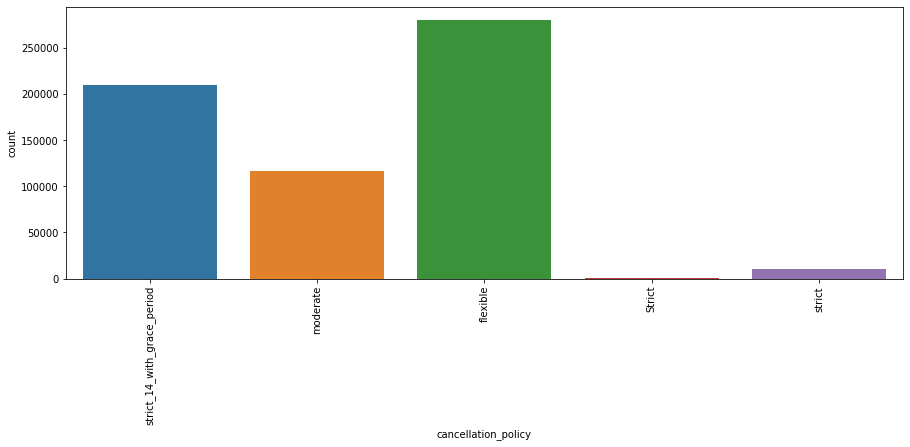

In [71]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [72]:
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
print(tabela_cancellation)

flexible                       280480
strict_14_with_grace_period    209596
moderate                       116322
strict                          10067
Strict                            167
Name: cancellation_policy, dtype: int64


In [73]:
# criar uma coluna auxiliar para agrupar imoveis com quantidade menor de 10000
colunas_agrupada = []

for tipo in tabela_cancellation.index:
  if tabela_cancellation[tipo] < 10000:
    colunas_agrupada.append(tipo)

print(colunas_agrupada)

['Strict']


In [74]:
for tipo in colunas_agrupada:
  base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())

flexible                       280480
strict_14_with_grace_period    209596
moderate                       116322
strict                          10234
Name: cancellation_policy, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


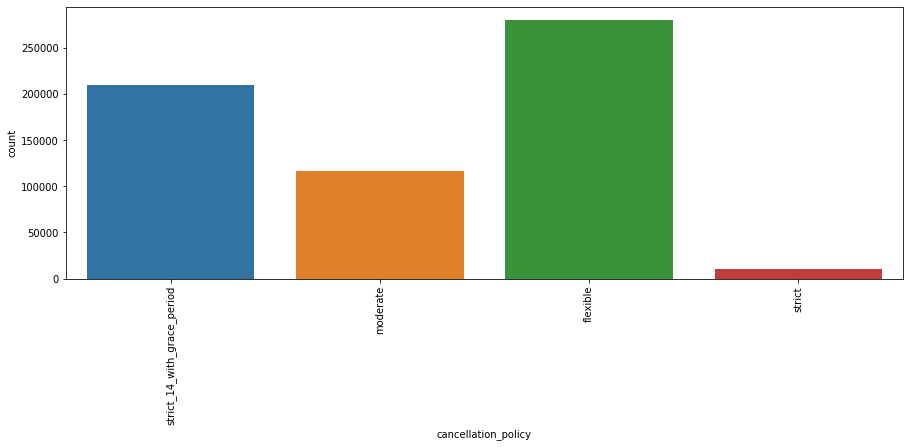

In [75]:
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- amenities

Como temos uma divesidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como parâmetro para o nosso modelo.                               

In [76]:
print(base_airbnb['amenities'].iloc[0])

{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Building staff","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}


In [77]:
# Usar os "split ','" para separar cada ítem por vígula e somá-los, tendo a quantidade total de ítens
print(base_airbnb['amenities'].iloc[0].split(','))

# Para contar o número de ítens
print(len(base_airbnb['amenities'].iloc[0].split(',')))

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Building staff"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [78]:
# Vamos criar uma nova coluna com a Quantidade de amenities e depois excluir a existente
#'apply(len)' é para aplicar a soma
base_airbnb['n-amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

In [79]:
# Tirar a coluna de amenities
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(616632, 20)

- Como a coluna criada 'n_amenities' passa a ser uma coluna númerica, devemos verificar os outliers

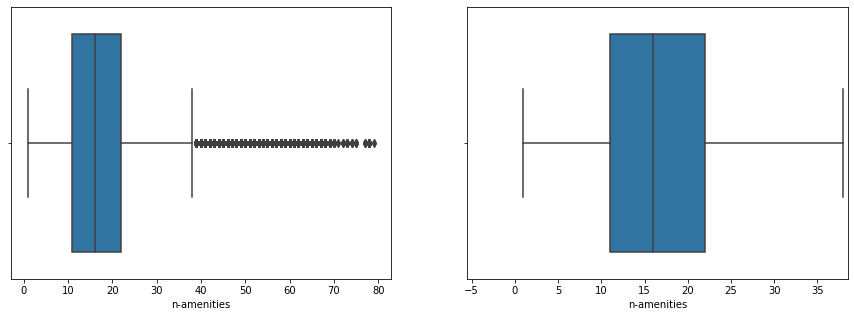

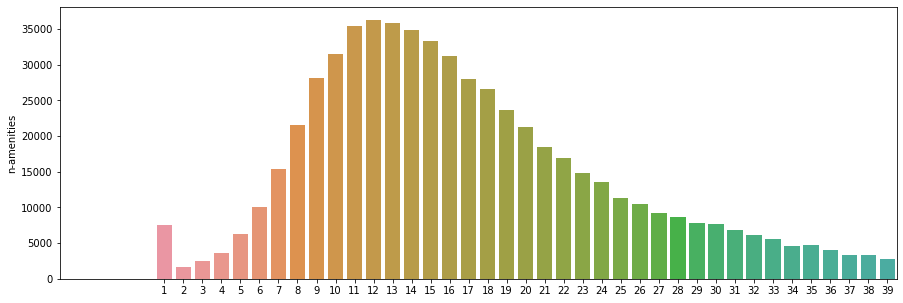

In [80]:
diagrama_caixa(base_airbnb['n-amenities'])
grafico_barra(base_airbnb['n-amenities'])

In [81]:
# Excluir os outliers
# Usando a função 'excluir_outliers'. Lembrando que o returno da função é uma tupla = df, qtde_linhas
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n-amenities')
print('{} linhas removidas'.format(linhas_removidas))

24477 linhas removidas


### Visualização de Mapa das Propriedades

In [82]:
# Definir uma amostra do dataframe, pegando 'n' valores do dataframe
amostra = base_airbnb.sample(n=50000)

In [83]:
# Definindo o centro do mapa
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

In [84]:
# Imprimindo o mapa
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5, 
                         center = centro_mapa, zoom=10,
                         mapbox_style='stamen-terrain')

mapa.show()

### Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0

- Features de Categoria (features em que os valores das colunas são textos) vamos utilizar o método de encoding de variáveis dummies

In [85]:
print(base_airbnb.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes', 'n-amenities'],
      dtype='object')


In [86]:
# Tratar features verdadeiro e falso
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
  base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
  base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0


In [87]:
colunas_categoria = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

In [88]:
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categoria)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,0,2.0,-22.96592,-43.17896,5,1.0,2.0,2.0,302.0,58.0,...,1,0,0,0,0,1,0,0,0,1
1,0,3.0,-22.97712,-43.19045,3,1.0,1.0,2.0,159.0,45.0,...,1,0,0,0,0,1,0,0,0,1
2,1,1.0,-22.98302,-43.21427,3,1.0,1.0,2.0,252.0,39.0,...,1,0,0,0,0,1,0,0,0,1
3,1,1.0,-22.98816,-43.19359,3,1.5,1.0,2.0,350.0,58.0,...,1,0,0,0,0,1,0,0,0,1
4,1,1.0,-22.98127,-43.19046,2,1.0,1.0,2.0,221.0,80.0,...,1,0,0,0,0,1,0,0,0,1


### Modelo de Previsão

- Metricas de Avaliação

In [89]:
# função para avaliar modelo: def avaliar_modelo(nome_modelo, y_teste, previsão):

def avaliar_modelo(nome_modelo, y_teste, previsao):
  r2 = r2_score(y_teste, previsao)
  RSME = np.sqrt(mean_squared_error(y_teste, previsao))
  return f'Modelo{nome_modelo}:\nR2:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos modelos a serem testados:
    1. RandomForrest
    2. LinearRegression
    3. ExtraTree

In [90]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et,
           }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separar os dados em treino e teste + Treino do Modelo

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

ModeloRandomForest:
R2:97.45%
RSME:44.08
ModeloLinearRegression:
R2:34.15%
RSME:223.91
ModeloExtraTrees:
R2:97.75%
RSME:41.39


### Análise do Melhor Modelo

In [92]:
for nome_modelo, modelo in modelos.items():
#testar
  previsao = modelo.predict(X_test)
  print(avaliar_modelo(nome_modelo, y_test, previsao))

ModeloRandomForest:
R2:97.45%
RSME:44.08
ModeloLinearRegression:
R2:34.15%
RSME:223.91
ModeloExtraTrees:
R2:97.75%
RSME:41.39


- Modelo escolhido como melhor modelo: ExtraTreesRegressior

    Esse foi o modelo com maior R2 e o menor RMSE, como não houve uma grande diferença de velocidade para treino e previsão desse modelo com o modelo RandomForestRegresion (que teve resultados próximos),vamos escolher o ExtraTrees.

    O modelo de LinearRegression não obteve resultados satisfatórios 

    Resultado das métricas no Modelo Vencedor:<br>
    ModeloExtraTrees:

    R2:97.75%
    
    RSME:41.39

### Ajustes e Melhorias no Melhor Modelo




In [93]:
print(modelo_et.feature_importances_)

[0.01469354 0.0354585  0.09832351 0.10218157 0.07223195 0.06302421
 0.12372687 0.04948706 0.09065704 0.08707464 0.01910353 0.
 0.00991119 0.00425696 0.08680078 0.01186189 0.00110525 0.00367011
 0.00053652 0.00079557 0.0005381  0.00547704 0.00177374 0.00067922
 0.00164933 0.00171837 0.0665201  0.00023064 0.00451417 0.00164784
 0.0024995  0.00261414 0.01757145 0.01025079 0.00075327 0.00666161]


In [94]:
print(X_train.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'ano',
       'mes', 'n-amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Other', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Outros', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [95]:
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
display(importancia_features)

,0
host_is_superhost,0.014694
host_listings_count,0.035458
latitude,0.098324
longitude,0.102182
accommodates,0.072232
bathrooms,0.063024
bedrooms,0.123727
beds,0.049487
extra_people,0.090657
minimum_nights,0.087075


In [96]:
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

,0
bedrooms,0.123727
longitude,0.102182
latitude,0.098324
extra_people,0.090657
minimum_nights,0.087075
n-amenities,0.086801
accommodates,0.072232
room_type_Entire home/apt,0.066520
bathrooms,0.063024
beds,0.049487


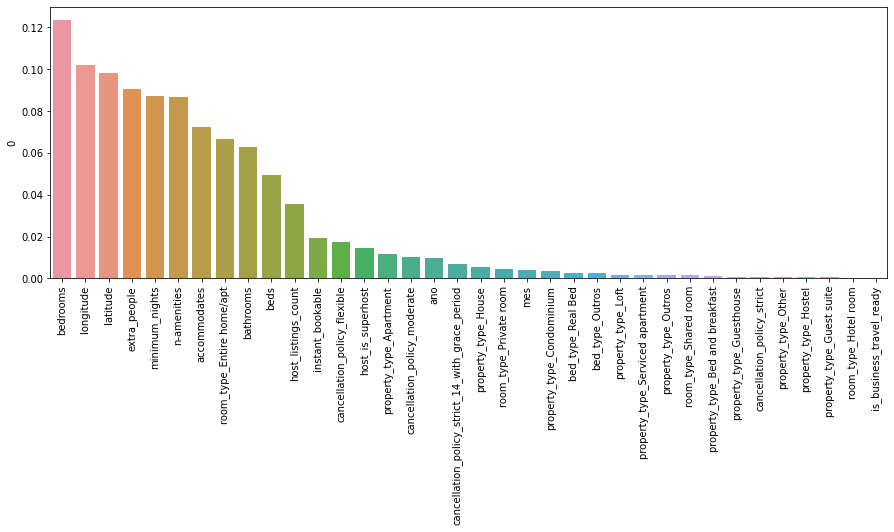

In [97]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais do Modelo

  - is_business_travel_ready parece não ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [98]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

ModeloExtraTrees:
R2:97.74%
RSME:41.52


In [99]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n-amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Other', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
ModeloExtraTrees:
R2:97.72%
RSME:41.64


### Conclusão

Melhor modelo:

  - ExtraTreesRegressor:

      R2:97.75%
    
      RSME:41.39

  Mesmo exluindo algumas colunas, com pouco impacto para o modelo, o mesmo não apresentou melhoria.